In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import pymc3 as pm
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
sns.set()
import japanize_matplotlib 

# irisの品種分類

In [4]:
iris=sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## データのEDA

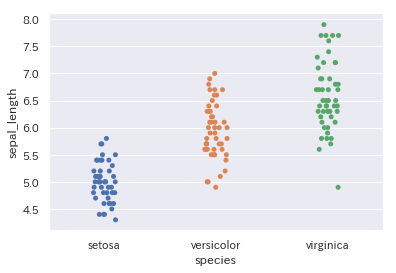

In [9]:
sns.stripplot(x='species',y='sepal_length',data=iris,jitter=True)

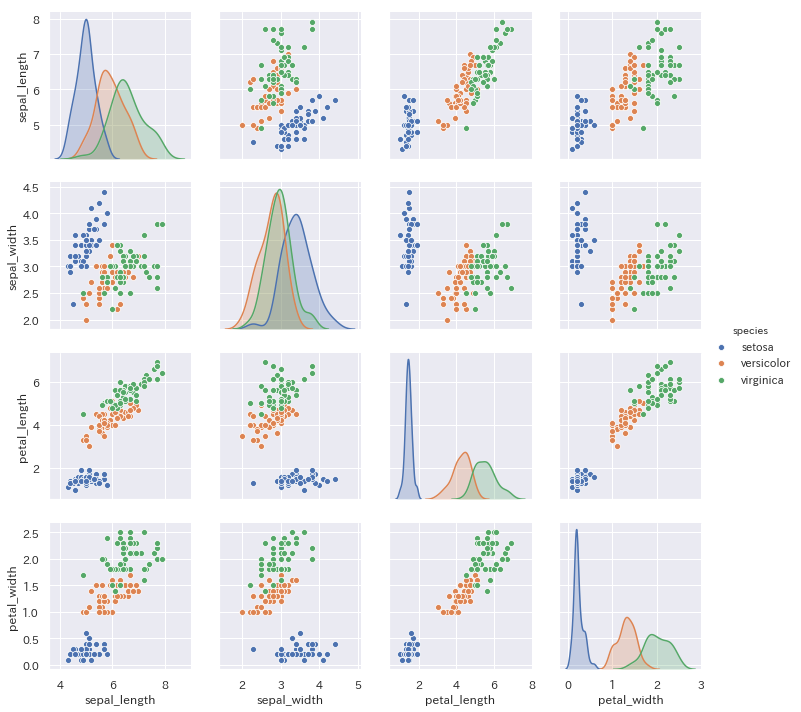

In [15]:
sns.pairplot(data=iris,diag_kind='kde',hue='species')

## setosaとversicolorをガク片のみで分類する

In [87]:
df=iris.query("species==('setosa','versicolor')")
y_0,cat=pd.factorize(df['species'])
x_0=df['sepal_length'].values*10

## モデル構築

In [88]:
with pm.Model() as model_0:
    alpha=pm.Normal('alpha',mu=0,sd=10)
    beta=pm.Normal('beta',mu=0,sd=10)
    
    mu=alpha+beta*x_0
    # ロジスティック回帰で[0-1]に写像する
    theta=pm.Deterministic('theta',1/(1+pm.math.exp(-mu)))
    
    # 決定境界
    bq=pm.Deterministic('bq',-alpha/beta)
    
    # 尤度
    yl=pm.Bernoulli('yl',p=theta,observed=y_0)
    
    # サンプリング
    start=pm.find_MAP()
    step=pm.NUTS()
    trace_0=pm.sample(5000,step,start)
    


logp = nan, ||grad|| = 0: 100%|██████████| 84/84 [00:00<00:00, 2294.46it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:25<00:00, 855.41draws/s]
The acceptance probability does not match the target. It is 0.8951607973907196, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8900798253082287, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ae8e1d0>,
      dtype=object)

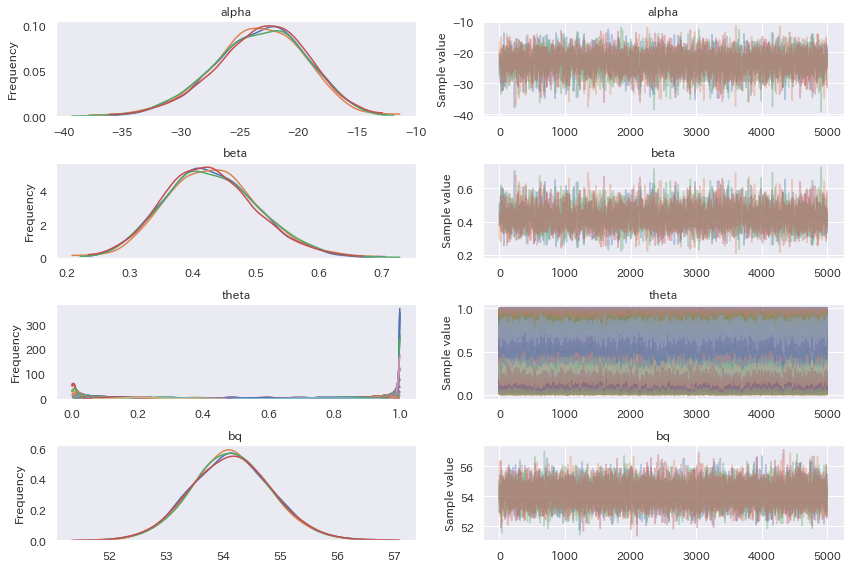

In [89]:
pm.traceplot(trace_0)

In [90]:
pm.summary(trace_0,['alpha','beta','bq'])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-23.260898,3.960897,0.070784,-31.363247,-15.856331,2837.364649,1.000651
beta,0.429610,0.073388,0.001303,0.283812,0.570867,2859.752018,1.000649
bq,54.154006,0.696098,0.005737,52.771798,55.523294,17009.159709,0.999904


In [91]:
chain_0=trace_0[100:]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11ec96fd0>,
      dtype=object)

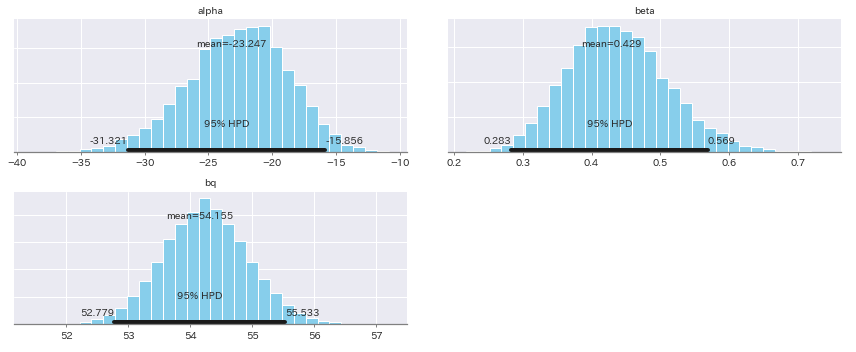

In [92]:
pm.plot_posterior(chain_0,['alpha','beta','bq'])

## 可視化

Text(0, 0.5, 'オークションに勝つ確率')

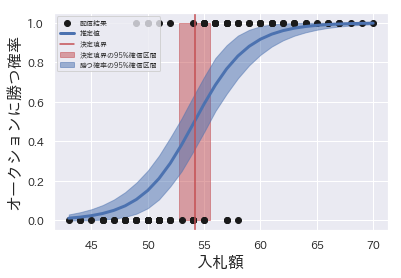

In [93]:
theta=chain_0['theta'].mean(axis=0)
idx=np.argsort(x_0)

plt.plot(x_0,y_0,'o',c='k',label='配信結果')
plt.plot(x_0[idx],theta[idx],c='b',lw=3,label='推定値')
plt.axvline(chain_0['bq'].mean(),ymax=1,c='r',label='決定境界')
# 決定境界の95%確信区間
bq_hpd=pm.hpd(trace_0['bq'])
plt.fill_betweenx([0,1],*bq_hpd,color='r',alpha=0.5,label='決定境界の95%確信区間')

# 観測データ
# 確率の95%確信区間
theta_hpq=pm.hpd(trace_0['theta'])[idx]
plt.fill_between(x_0[idx],theta_hpq[:,0],theta_hpq[:,1],color='b',alpha=0.5,label='勝つ確率の95%確信区間')
plt.legend(loc='upper left',fontsize=7)
plt.xlabel('入札額',fontsize=16)
plt.ylabel('オークションに勝つ確率',fontsize=16)

5.2810074250105385 5.559507411976096
